In [16]:
using Random
using Distributions
using LinearAlgebra
include("../Inversion/Plot.jl")
include("../Inversion/GMKI.jl")
include("../Inversion/KI.jl")
include("../Inversion/RWMCMC.jl")
include("../Inversion/SMC.jl")
include("../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

# 1-Parameter Square Map
The posterior distribution is studied  numerically on the following nonlinear 1-parameter problem:

$$
\begin{equation*}
y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \theta^2. 
\end{equation*}
$$    


We assume the observation is $y = 1$ and the piror is $\mathcal{N}(3, 2^2)$, we consider the following cases

$$
\begin{align*}
&A: \eta \sim \mathcal{N}(0, 1^2)\\
&B: \eta \sim \mathcal{N}(0, 0.5^2)\\
&C: \eta \sim \mathcal{N}(0, 0.2^2)\\
\end{align*}
$$ 

In [17]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

function p1(s_param, θ::Array{Float64,1})  
    return [θ[1] ;]
end

function p1_aug(s_param, θ::Array{Float64,1})  
    return [θ[1] ; θ[1]]
end

function p1_aug_derivative(s_param, θ::Array{Float64,1})  
    return [θ[1] ; θ[1]], [1.0 ; 1.0]
end



function p2(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ;]
end

function p2_aug(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ; θ[1]]
end

function p2_aug_derivative(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ; θ[1]], [2θ[1] ; 1.0]
end

p2_aug_derivative (generic function with 1 method)

# Numerical Methods

The posterior distribution is approximated by 
* MCMC method (reference):  a step size $1.0$ and $5\times10^6$ samples (with a $10^6$ sample burn-in period).
* SMC method: $10^3$ particles and $10^2$ uniform steps is also applied for comparison. 
* UKI method: $2$ initial conditions are considered, which are $\theta_0\sim\mathcal{N}(-1, 0.5^2)$ and $\theta_0\sim\mathcal{N}(1, 0.5^2)$. We find that only the hyperbola discontinuous problem is sensitive to the initial covariance for the UKI. The hyperparameters of UKI are chosen at the $n$-th iteration, as following
$$ r = r_0 \quad
    \Sigma_{\nu} = 2\Sigma_{\eta} \quad \textrm{ and } \quad \Sigma_{\omega} =  C_n
$$
here $r_0$ is the prior mean. It is worth mentioning the artificial evolution error covariance $\Sigma_{\omega}$ is updated as the estimated covariance $C_{n}$.

In [18]:
function Posterior_Plot(forward::Function;  θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0, 
                        Run_EKS = false, Run_SMC = false, Run_MCMC = false, plot_every = 1)
    
    forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)
    
    N_y, N_θ = 1, 1
    s_param = Setup_Param(N_θ, N_y)
    y = forward(s_param, [θ_ref;])
    Σ_η = reshape([σ_η^2], (N_y, N_y))
    # prior distribution
    μ0,  Σ0   = [μ_0;], reshape([σ_0^2],  (N_θ, N_θ))
    


    # compute posterior distribution by UKI
    update_freq = 1
    N_iter = 100
    N_modes = 3
    θ0_w  = [0.5; 0.5; 0.5]
    θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)
    
    θ0_mean[1, :]    .= -3.0
    θθ0_cov[1, :, :] .=  reshape([0.5^2],  (1, 1))
    θ0_mean[2, :]    .=  3.0
    θθ0_cov[2, :, :] .=  reshape([0.5^2],  (1, 1))
    θ0_mean[3, :]    .=  -2.0
    θθ0_cov[3, :, :] .=  reshape([0.5^2],  (1, 1))
    
    s_param_aug = Setup_Param(1,2)
    y_aug = [y ; μ0]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
    γ = 1.0
    # Δt = γ/(1+γ)
    ukiobj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1")
    


    if Run_MCMC
        # compute posterior distribution by MCMC
        logρ(θ) = log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0) 
        step_length = 1.0
        N_iter , n_burn_in= 5000000, 1000000
        us = RWMCMC_Run(logρ, μ0, step_length, N_iter)
    end
    
    # compute posterior distribution by SMC
    if Run_SMC
        N_ens = 1000
        M_threshold = Float64(N_ens)
        N_t = 100
        step_length = 1.0
        smcobj = SMC_Run(s_param, forward,
        μ0, Σ0, 
        y, Σ_η,
        N_ens, 
        step_length,
        M_threshold,
        N_t) 
    end

    if Run_EKS
        N_iter = 100
        N_ens  = 1000
        eksobj = EKS_Run(s_param, forward, 
        μ0, Σ0,
        N_ens,
        y, Σ_η,
        N_iter)
        @info "EKS large J t = ", sum(eksobj.Δt)
    end
    
    
    # visualization 

    # Visualize different iterations
    for iter  = 1:plot_every:length(ukiobj.θ_mean)
        nrows, ncols = 1, 1
        fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
        # plot UKI results 

        Nx = 1000
        xxs, zzs = zeros(N_modes, Nx), zeros(N_modes, Nx)
        θ_min = minimum(ukiobj.θ_mean[iter][:,1] .- 5sqrt.(ukiobj.θθ_cov[iter][:,1,1]))
        θ_max = maximum(ukiobj.θ_mean[iter][:,1] .+ 5sqrt.(ukiobj.θθ_cov[iter][:,1,1]))
        
        for i =1:N_modes
            xxs[i, :], zzs[i, :] = Gaussian_1d(ukiobj.θ_mean[iter][i,1], ukiobj.θθ_cov[iter][i,1,1], Nx, θ_min, θ_max)
            zzs[i, :] *= exp(ukiobj.logθ_w[iter][i])
            ax.plot(xxs[i,:], zzs[i,:], marker= "o", linestyle=":", color="C"*string(i), fillstyle="none", markevery=100, label="UKI Modal "*string(i))
        end
        ax.plot(xxs[1,:], sum(zzs, dims=1)', marker= "*", linestyle="-", color="C0", fillstyle="none", markevery=100, label="UKI")
        


        
        if Run_EKS
            # plot EKS results 
            θ = eksobj.θ[end]
            ax.hist(θ, bins = 40, density = true, histtype = "step", label="EKS", color="C4")
            ax.legend()
        end
        

        if Run_MCMC
            # plot MCMC results 
            ax.hist(us[n_burn_in:end, 1], bins = 100, density = true, histtype = "step", label="MCMC", color="C3")
        end


        if Run_SMC
            # plot SMC results 
            θ = smcobj.θ[end]
            weights = smcobj.weights[end]
            ax.hist(θ, bins = 20, weights = weights, density = true, histtype = "step", label="SMC", color="C0")  
        end

        ax.legend()
    end
    
    
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    θ_w = exp.(hcat(ukiobj.logθ_w...))
    for i =1:N_modes
        ax.plot(θ_w[i, :], "--o", label="mode"*string(i))
    end
    ax.legend()
end

Posterior_Plot (generic function with 1 method)

("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.25;;], [-3.0], [-3.2182769595683074], 0.409764703494922, 0.8195294069898438)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.25;;], [3.0], [2.9739783614351754], 0.4999986888466537, 0.9999973776933072)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.25;;], [-2.0], [-1.8296466069254282], 0.40012980485345856, 0.8002596097069169)
logθ_w_n = [68.62339671865848, 45.58557948506365, 3.1076990328103173]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.04869025765425872;;], [-1.8770724605094335], [-1.8885587797824184], 0.46974321749577147, 1.0)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.056026678810814856;;], [1.8123159929620203], [1.79999467154

logθ_w_n = [-0.8640739413969998, -0.8555701987589661, -0.2360680537844397]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.21667273930662784;;], [-0.9190841682852174], [-1.042589315335962], 0.2672151783712772, 0.9266177713221431)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.22396001920684458;;], [-0.91688466851005], [-1.050043338855261], 1.7990907850418426e-44, 2.3966435981387754e-22)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.19423450383641627;;], [1.1142395521595314], [1.1290088249468142], 0.5846715101567806, 0.9717799375181388)
logθ_w_n = [-0.8625576770413461, -0.8549529542386191, -0.23535575074362522]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.2262438783857606;;], [-0.9095044982044156], [-1.0373194853379082], 0.2841947204360905, 

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("updata : θ_mean = ", [-3.0; 3.0; -2.0;;], " θ_p_mean = ", [-3.2182769595683074; 2.9739783614351754; -1.8296466069254282;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-1.8770724605094335; 1.8123159929620203; -1.2821506607363642;;], " θ_p_mean = ", [-1.8885587797824184; 1.7999946715463193; 0.19620571126248182;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-1.577847438967388; 1.5509899209988636; 0.32209829675626833;;], " θ_p_mean = ", [-1.590293151042407; 1.5377632611984609; 0.19446968711162052;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-1.375167678361449; 1.3866075062481757; 0.418976758273354;;

("mode : ", 3, [0.19316453448644536;;], [1.1283159417291082], [1.1507377520549686], 0.5614038066460509, 0.964663665415766)
logθ_w_n = [-0.8584253200118286, -0.8584213778217401, -0.23223329935421028]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.25078825737386273;;], [-0.8874312816590229], [-1.0253140605009687], 0.3126705778425186, 0.9223883418611863)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.2508499370500954;;], [-0.8873748867049498], [-1.0253105784914698], 2.1165001680688485e-44, 2.399740438459906e-22)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.19312664459298592;;], [1.1283347555812142], [1.1507639173448758], 0.5613475135505895, 0.9646539590339488)
logθ_w_n = [-0.8584060268865084, -0.8583849757108636, -0.23222915877395425]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i]

("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.2510018154872748;;], [-0.8872680370472721], [-1.025246618512212], 2.1175603160609476e-44, 2.399785337866306e-22)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.19304797523933082;;], [1.128373781139585], [1.1508182814863883], 0.5612304271185289, 0.9646337193138578)
logθ_w_n = [-0.8583647714431226, -0.8583649321770758, -0.23222055106512413]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.25100194952897836;;], [-0.887268269015258], [-1.0252469575579504], 0.31281724655646664, 0.9223584146918161)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.2510022376057959;;], [-0.8872678824835545], [-1.0252467458957448], 2.1175623468622958e-44, 2.399785301127285e-22)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_

("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.25100284474623974;;], [-0.8872675871729879], [-1.0252466755935898], 2.117566854643057e-44, 2.399785627550373e-22)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.19304748597631508;;], [1.128374024100558], [1.1508186198121466], 0.5612296972716707, 0.9646335934459601)
logθ_w_n = [-0.8583645135219281, -0.8583645150917516, -0.2322204974744743]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.25100284617436286;;], [-0.887267588015006], [-1.025246678013708], 0.31281786446226245, 0.9223582899699705)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.2510028470889711;;], [-0.8872675860582653], [-1.0252466761846912], 2.1175668625278078e-44, 2.399785626289697e-22)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_m

┌ Info: ("updata : θ_mean = ", [-0.8872708515429; -0.88727064479458; 1.128373236723211;;], " θ_p_mean = ", [-1.0252480172737455; -1.0252466203450372; 1.1508175234045463;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-0.887269794657289; -0.8872691830607301; 1.1283734918531079;;], " θ_p_mean = ", [-1.0252475836742059; -1.0252464136442754; 1.1508178786629977;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-0.8872690797410079; -0.8872684067341665; 1.128373664418355;;], " θ_p_mean = ", [-1.025247290305924; -1.0252464759734508; 1.1508181189544149;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-0.8872685961417613; -0.8872680370472721; 1.128373781139585;;], " θ_p_mean = ", [-1.025247091829028; -1.025246618512212; 1.1508182814863883;;])
└ @ Main /Users/huang/Desktop/Code/InverseProbl


("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.19304748392244486;;], [1.1283740251205172], [1.150818621232466], 0.5612296942078283, 0.9646335929175508)
logθ_w_n = [-0.8583645124392478, -0.8583645124490893, -0.23222049724949376]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.2510028499385248;;], [-0.8872675851560802], [-1.0252466768401423], 0.3128178670562047, 0.9223582894463574)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.25100284993888233;;], [-0.8872675851489612], [-1.0252466768293498], 2.1175668811982205e-44, 2.399785627444476e-22)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.19304748391964316;;], [1.1283740251219085], [1.1508186212344036], 0.5612296942036488, 0.96463359291683)
logθ_w_n = [-0.8583645124377711, -0.8583645124438289, -0

("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.2510028499542411;;], [-0.8872675851441214], [-1.0252466768351804], 2.1175668812727834e-44, 2.3997856274438054e-22)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.19304748391382265;;], [1.1283740251247993], [1.1508186212384286], 0.5612296941949665, 0.9646335929153328)
logθ_w_n = [-0.8583645124347028, -0.858364512434749, -0.23222049724854926]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.2510028499543268;;], [-0.8872675851440782], [-1.0252466768352155], 0.3128178670670941, 0.9223582894441593)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.2510028499543045;;], [-0.887267585144068], [-1.0252466768351685], 2.1175668812728954e-44, 2.3997856274437297e-22)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ

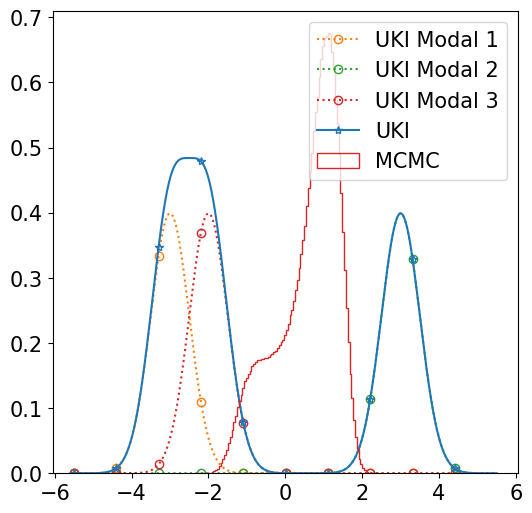

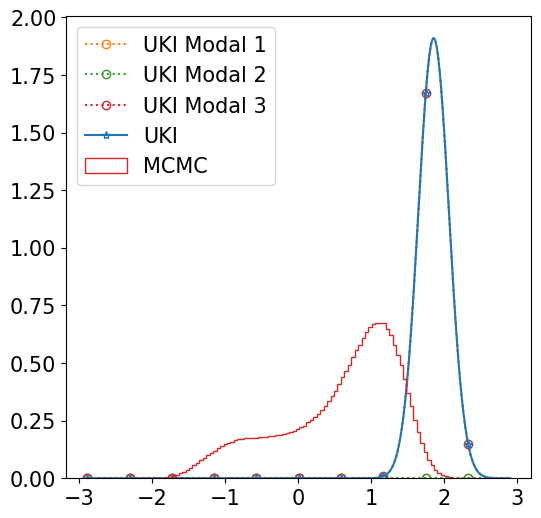

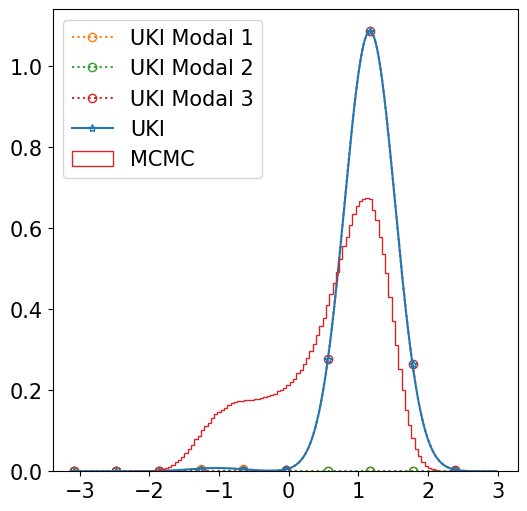

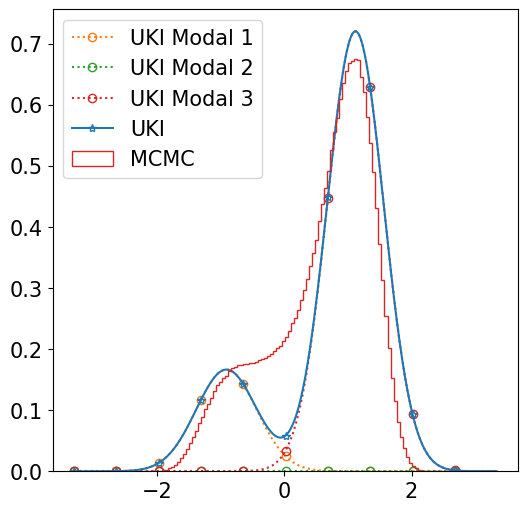

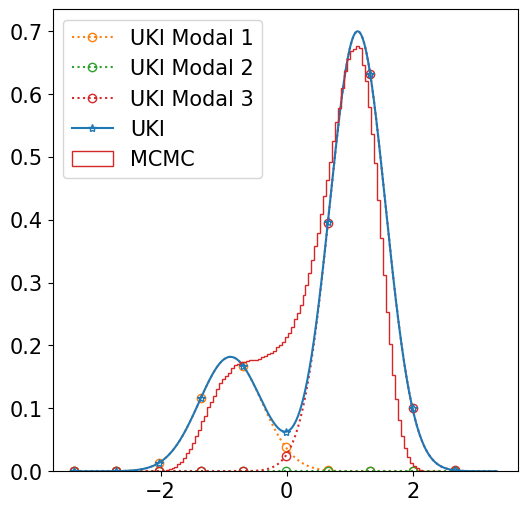

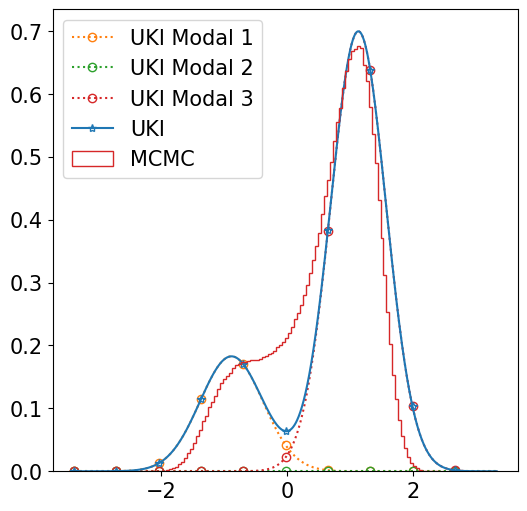

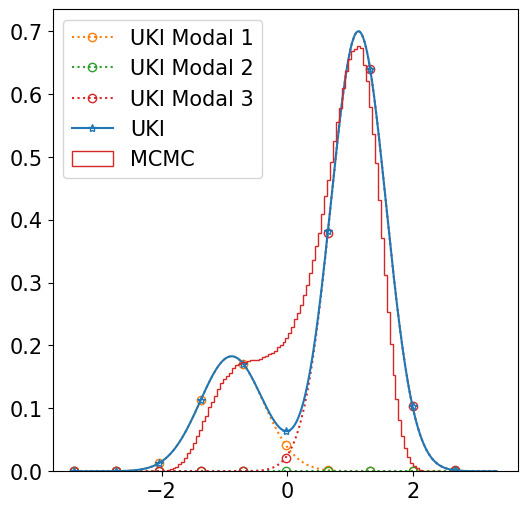

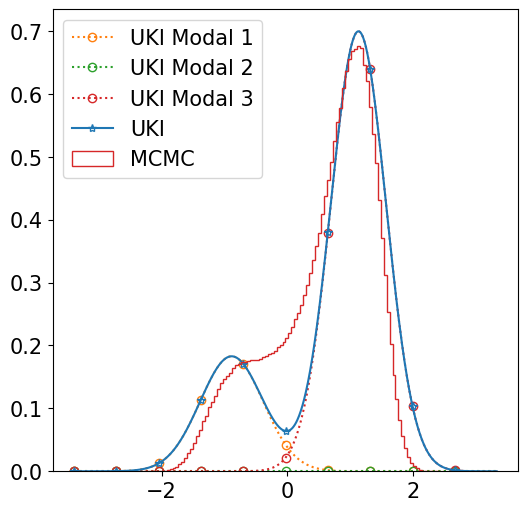

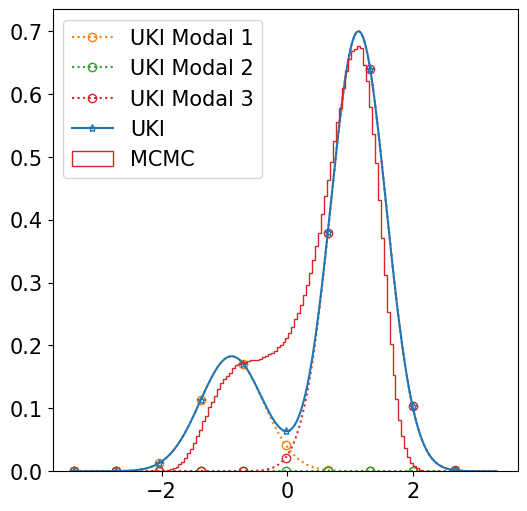

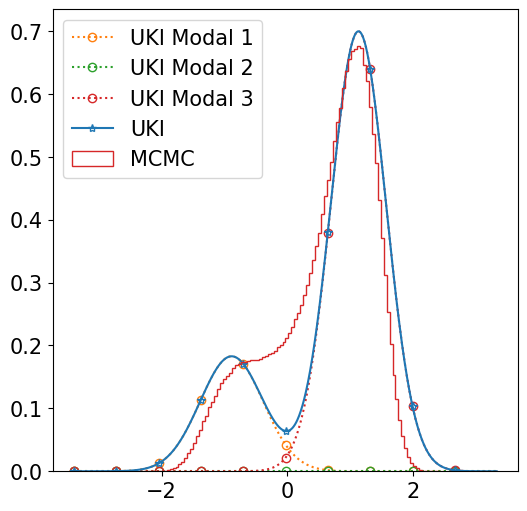

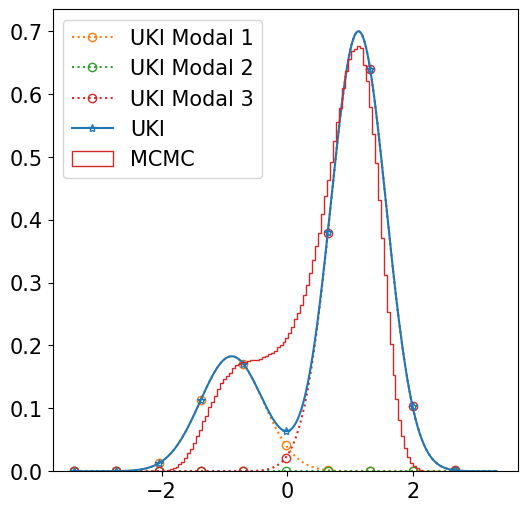

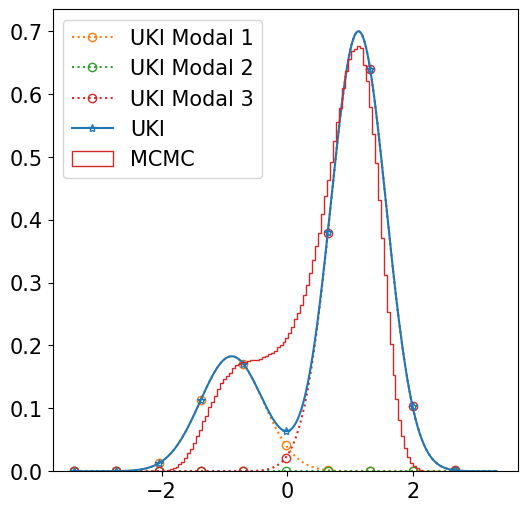

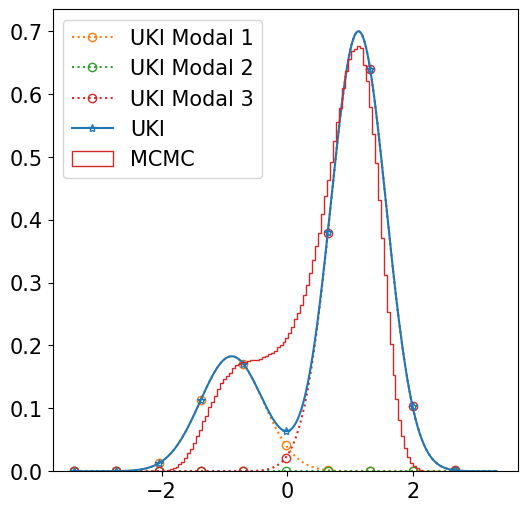

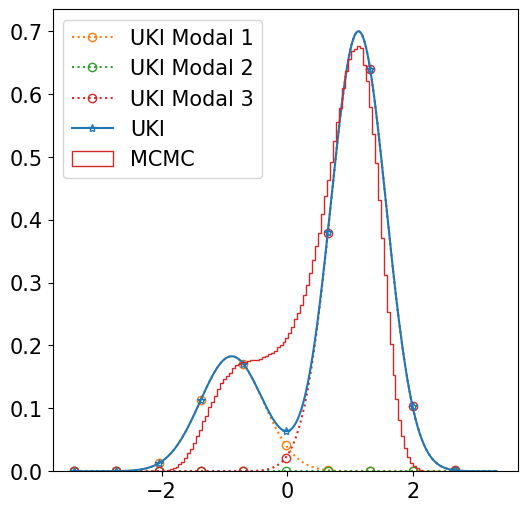

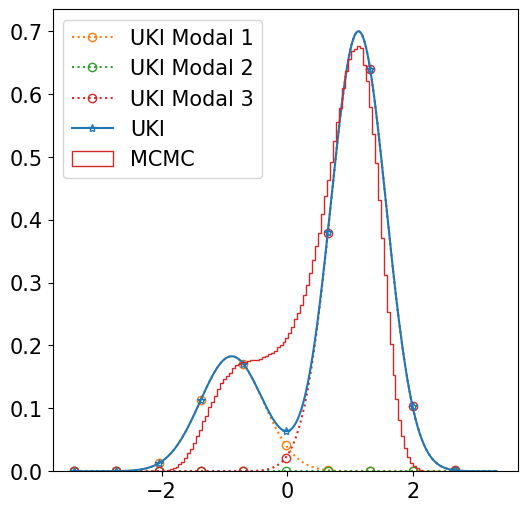

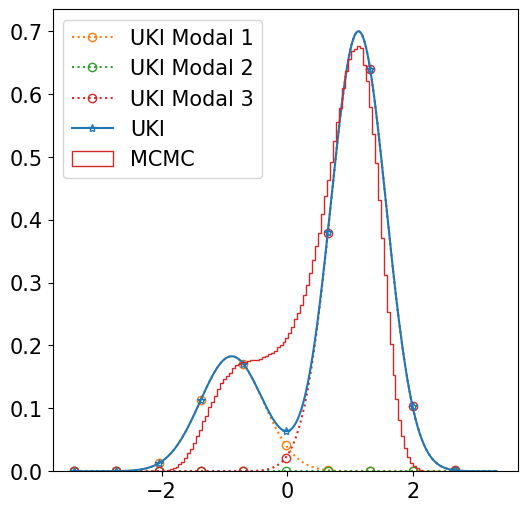

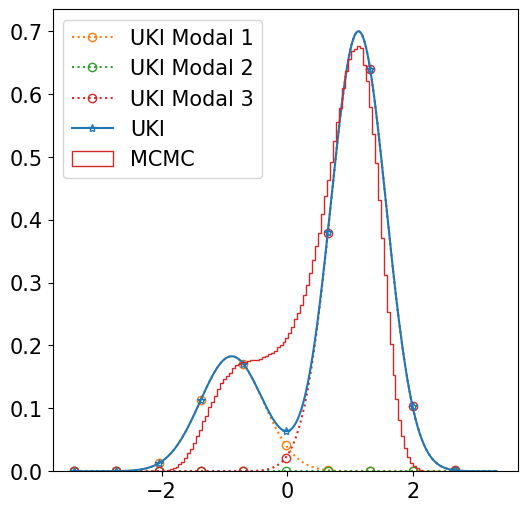

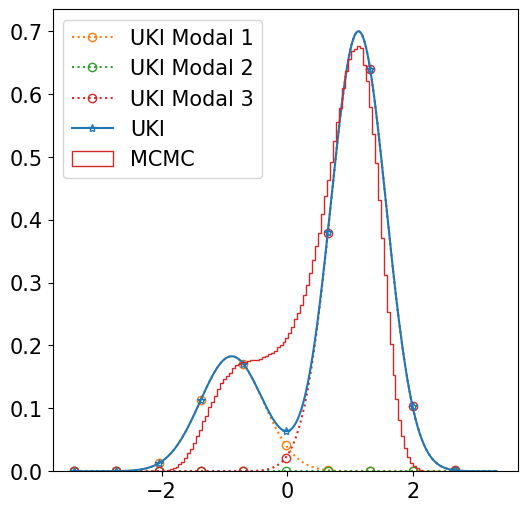

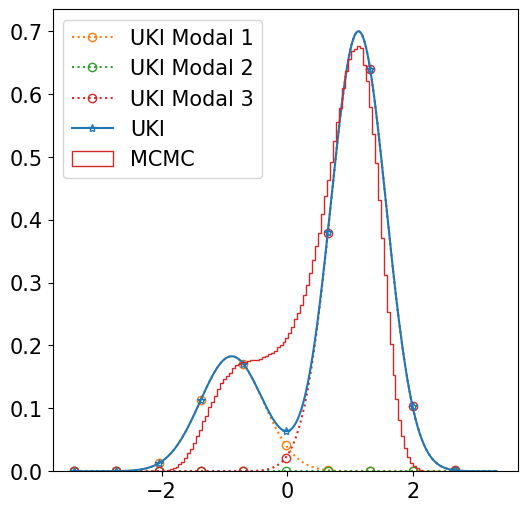

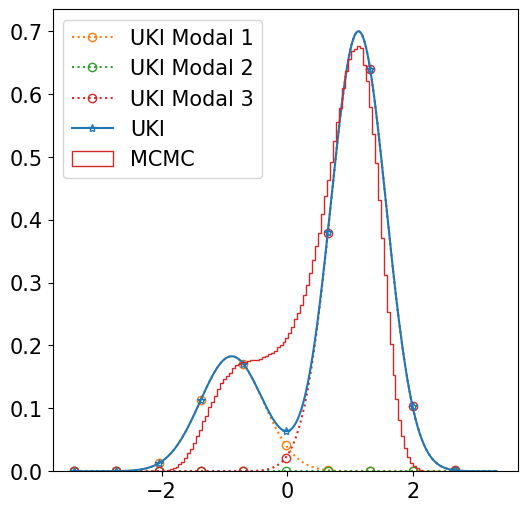

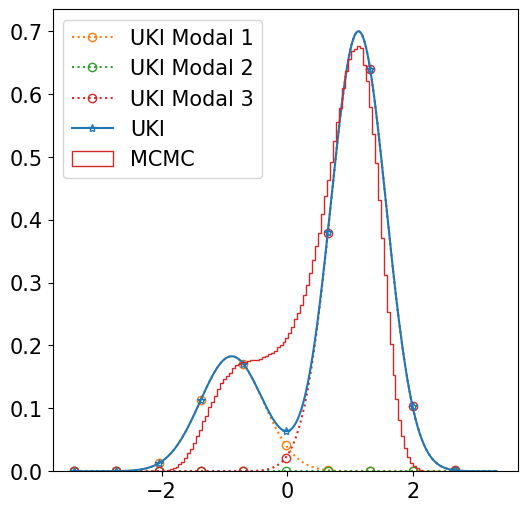

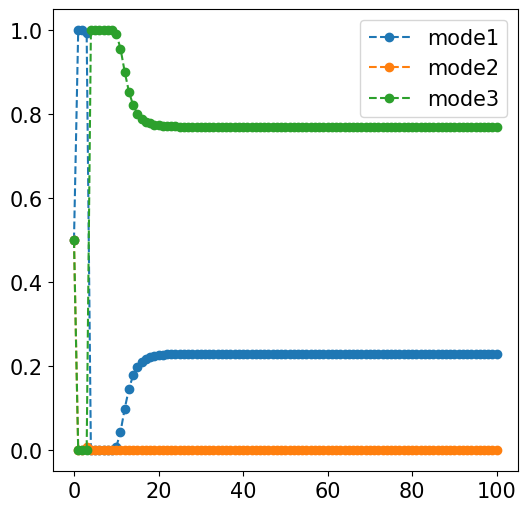


("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.19304748391378668;;], [1.1283740251248169], [1.1508186212384535], 0.5612296941949125, 0.9646335929153234)
logθ_w_n = [-0.8583645124346839, -0.8583645124346839, -0.23222049724854535]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.251002849954393;;], [-0.8872675851440279], [-1.0252466768351947], 0.3128178670671396, 0.92235828944415)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.2510028499543931;;], [-0.8872675851440278], [-1.0252466768351944], 2.117566881273017e-44, 2.399785627443587e-22)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.19304748391378662;;], [1.1283740251248169], [1.1508186212384535], 0.5612296941949124, 0.9646335929153234)
logθ_w_n = [-0.8583645124346837, -0.8583645124346837, -0.2

┌ Info: ("updata : θ_mean = ", [-0.887267585144809; -0.8872675851451522; 1.1283740251246286;;], " θ_p_mean = ", [-1.0252466768355155; -1.025246676836261; 1.1508186212381912;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-0.8872675851445562; -0.8872675851449681; 1.1283740251246897;;], " θ_p_mean = ", [-1.0252466768354123; -1.0252466768359483; 1.1508186212382756;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-0.8872675851443856; -0.8872675851447421; 1.1283740251247305;;], " θ_p_mean = ", [-1.0252466768353419; -1.0252466768356654; 1.1508186212383331;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-0.8872675851442698; -0.8872675851445246; 1.1283740251247585;;], " θ_p_mean = ", [-1.0252466768352941; -1.0252466768354487; 1.1508186212383726;;])
└ @ Main /Users/huang/Desktop/Code/In

PyObject <matplotlib.legend.Legend object at 0x1b28dfb80>

In [19]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0, Run_MCMC = true, plot_every = 5) 

("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.25;;], [-3.0], [-3.2182769595683074], 0.409764703494922, 0.8195294069898438)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.25;;], [3.0], [2.9739783614351754], 0.4999986888466537, 0.9999973776933072)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.25;;], [-2.0], [-1.8296466069254282], 0.40012980485345856, 0.8002596097069169)
logθ_w_n = [422.4677998039641, 291.74390084100855, 24.694455468674015]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.01743254566652247;;], [-1.804804972894169], [-1.8116778765046921], 0.3633625819769158, 1.0)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.020285654923498264;;], [1.712032428202947], [1.7046183977743

logθ_w_n = [-0.9767790429886741, -0.24424076678711631, -0.18414102933619225]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.06575390196250254;;], [-0.956258448751876], [-0.9778194797294933], 0.22125929087181995, 0.9927802407558943)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.061952791834864344;;], [1.02001101518063], [1.0089566221950232], 0.44718501654670934, 0.9982158501872911)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.04498373118718479;;], [1.092156289919071], [1.123790827132996], 1.5466502724790075e-65, 6.047492869849315e-33)
logθ_w_n = [-0.9768403127772171, -0.24422949145008002, -0.2044049119685488]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.06612692010849898;;], [-0.9559063562273485], [-0.9776196650429176], 0.2207788270856174

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("updata : θ_mean = ", [-3.0; 3.0; -2.0;;], " θ_p_mean = ", [-3.2182769595683074; 2.9739783614351754; -1.8296466069254282;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-1.804804972894169; 1.712032428202947; -1.22611924843469;;], " θ_p_mean = ", [-1.8116778765046921; 1.70461839777436; 0.023913518494405435;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-1.5007796290150952; 1.4378493554788387; 0.06993928591231104;;], " θ_p_mean = ", [-1.507798635943392; 1.4303314022059022; 0.3678762822951874;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-1.3281050958674425; 1.2876140420518685; 0.6117365409669621;;], 

logθ_w_n = [-0.9768631428241137, -0.24425229035912374, -0.2462339697043234]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.06661222412886723;;], [-0.9555420951977961], [-0.9774404008326245], 0.22043552584079135, 0.9925857303568967)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.06229369422809537;;], [1.0201602105243812], [1.009132964736485], 0.44849767732795115, 0.9981608101781159)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.05964501416830207;;], [1.0286633269713916], [1.0248363869351227], 9.37983474413168e-66, 4.564518753671425e-33)
logθ_w_n = [-0.976863145408968, -0.2442523048624348, -0.2461594554633469]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.06661232526543624;;], [-0.9555420231928353], [-0.9774403572649625], 0.2204356318346108, 

("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.06175661046993593;;], [1.0218425654118382], [1.0123097259103986], 8.209788993515437e-66, 4.270055985870464e-33)
logθ_w_n = [-0.9768631539554425, -0.2442523209084347, -0.24483178165736605]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.0666124565862575;;], [-0.9555419216754626], [-0.9774402919619821], 0.22043578927519966, 0.9925857043596518)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.06229363783195752;;], [1.0201602713416598], [1.009133038667156], 0.4484975353449545, 0.9981608023565937)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.06181715816917608;;], [1.0216519935490078], [1.011951712276815], 8.175785222345035e-66, 4.26125038888635e-33)
logθ_w_n = [-0.976863153961421, -0.2442523209106264, 

("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.06229363780961322;;], [1.0201602713473785], [1.0091330386785977], 0.448497535273928, 0.9981608023529908)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.062191429686038864;;], [1.0204791080910447], [1.0097379507828907], 7.964926544804132e-66, 4.2062920163899144e-33)
logθ_w_n = [-0.9768631539694111, -0.24425232091355073, -0.24437022535353226]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.06661245668064844;;], [-0.9555419215903971], [-0.977440291903471], 0.22043578941162645, 0.992585704348792)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.06229363780960714;;], [1.0201602713473814], [1.0091330386786022], 0.4484975352739071, 0.9981608023529897)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[

┌ Info: ("updata : θ_mean = ", [-0.955541922036766; 1.0201602713157283; 1.022302327418046;;], " θ_p_mean = ", [-0.9774402922117719; 1.0091330386166772; 1.0131715454047021;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-0.9555419218475587; 1.0201602713298847; 1.0220581841561946;;], " θ_p_mean = ", [-0.9774402920809077; 1.0091330386437243; 1.0127142348455511;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-0.9555419217383788; 1.0201602713374756; 1.0218425654118382;;], " θ_p_mean = ", [-0.9774402920054299; 1.00913303865872; 1.0123097259103986;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-0.9555419216754626; 1.0201602713416598; 1.0216519935490078;;], " θ_p_mean = ", [-0.9774402919619821; 1.009133038667156; 1.011951712276815;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblem


("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.06227391052195895;;], [1.0202217634789614], [1.0092498097089548], 7.918297584626579e-66, 4.194053977375866e-33)
logθ_w_n = [-0.9768631539694167, -0.2442523209135531, -0.2442753578764036]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.06661245668068862;;], [-0.9555419215903616], [-0.9774402919034472], 0.22043578941168493, 0.9925857043487872)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.06229363780959903;;], [1.0201602713473847], [1.0091330386786077], 0.44849753527387926, 0.9981608023529881)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.06227609479278168;;], [1.0202149537706586], [1.0092368808352856], 7.917061934796107e-66, 4.193729247331148e-33)
logθ_w_n = [-0.9768631539694167, -0.244252320913

("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.06229363780959903;;], [1.0201602713473847], [1.0091330386786077], 0.44849753527387926, 0.9981608023529881)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.0622898196827311;;], [1.020172171135903], [1.0091556398236186], 7.909296748051512e-66, 4.1916880415866426e-33)
logθ_w_n = [-0.9768631539694167, -0.2442523209135531, -0.24425679007864662]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.06661245668068862;;], [-0.9555419215903616], [-0.9774402919034472], 0.22043578941168493, 0.9925857043487872)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.06229363780959903;;], [1.0201602713473847], [1.0091330386786077], 0.44849753527387926, 0.9981608023529881)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p

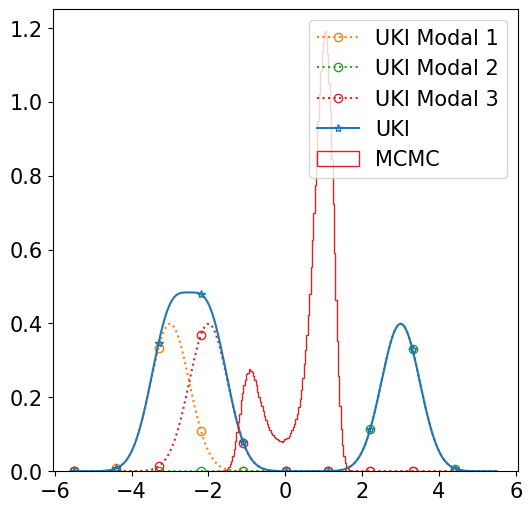

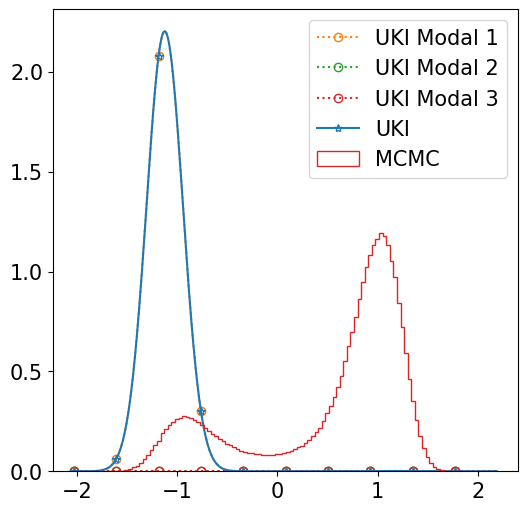

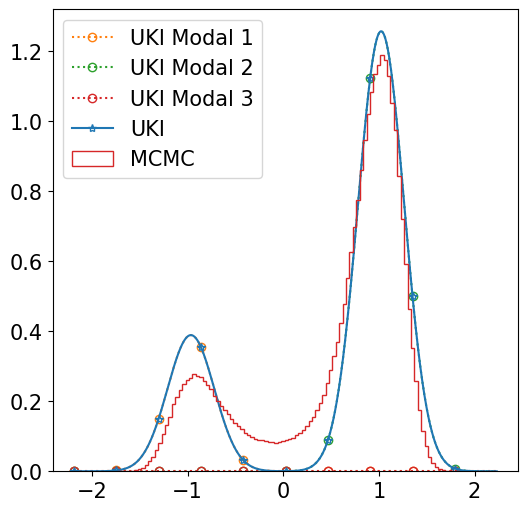

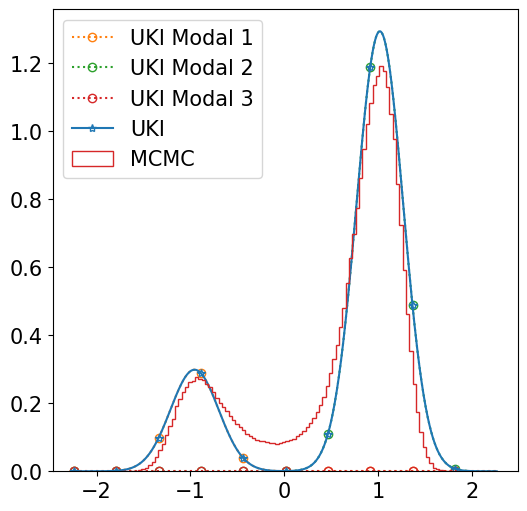

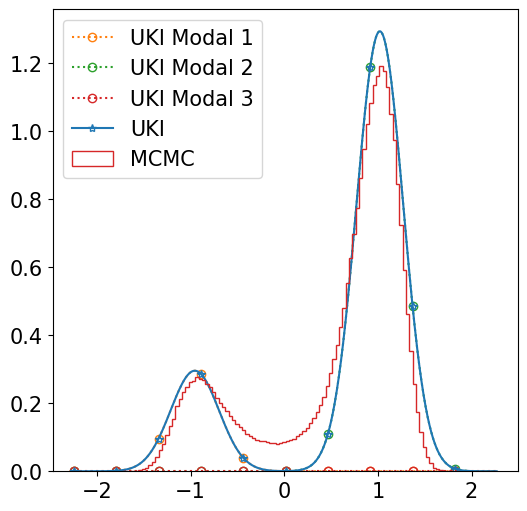

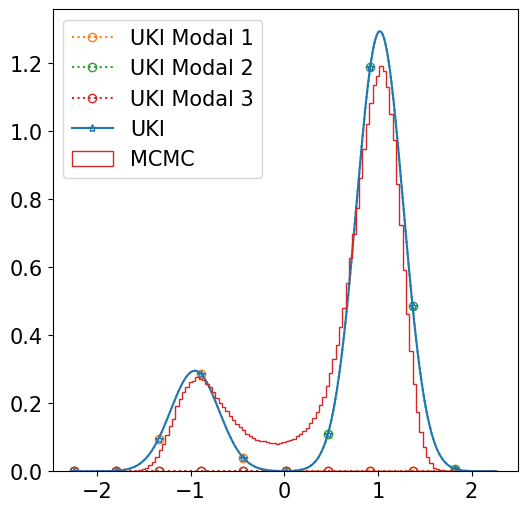

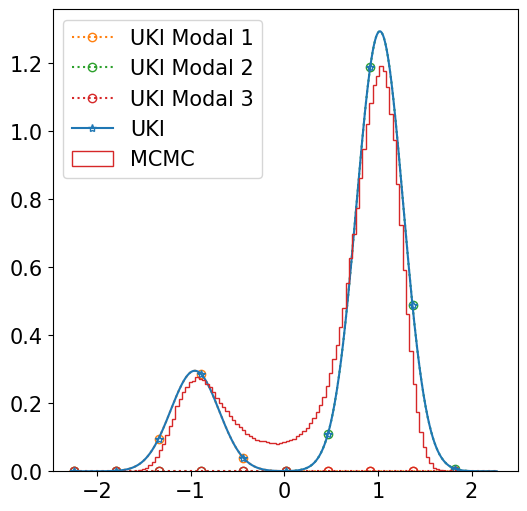

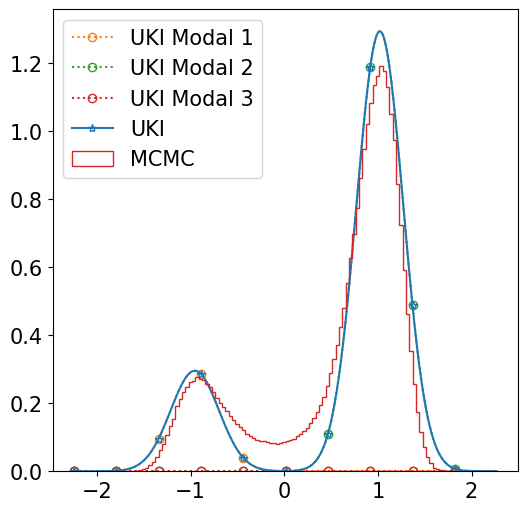

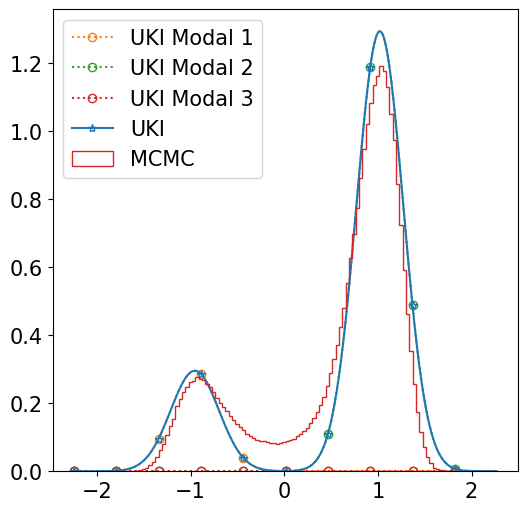

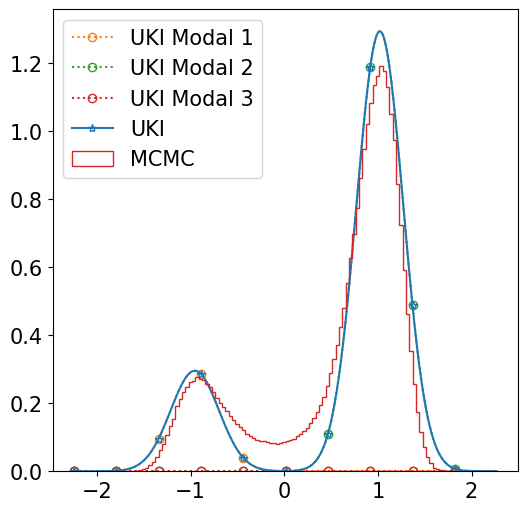

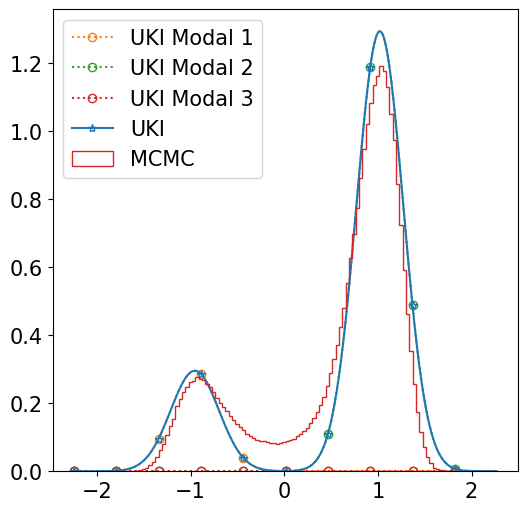

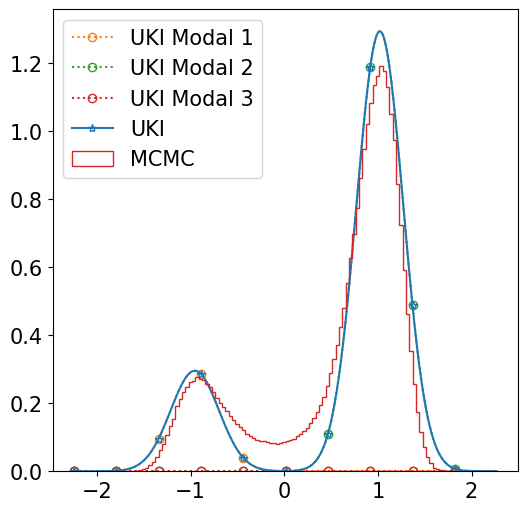

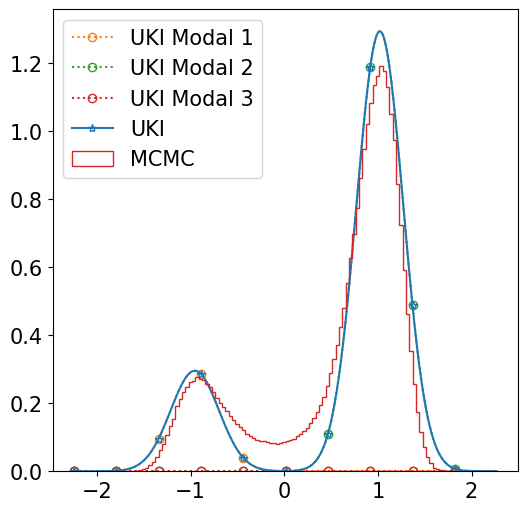

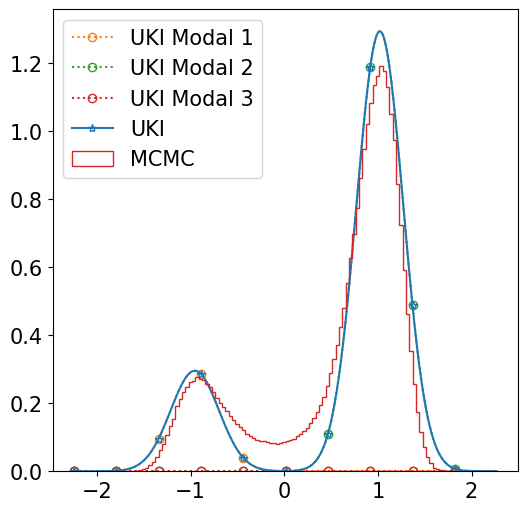

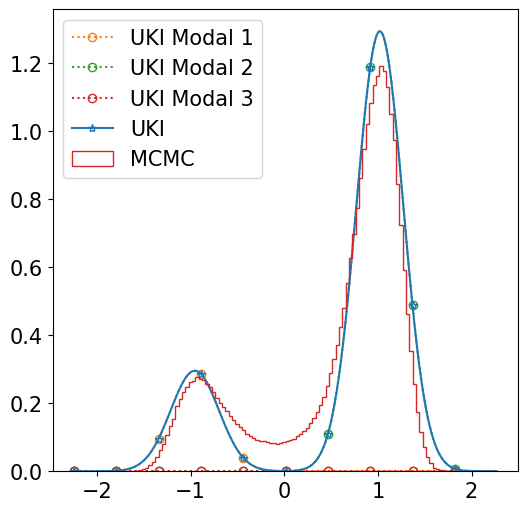

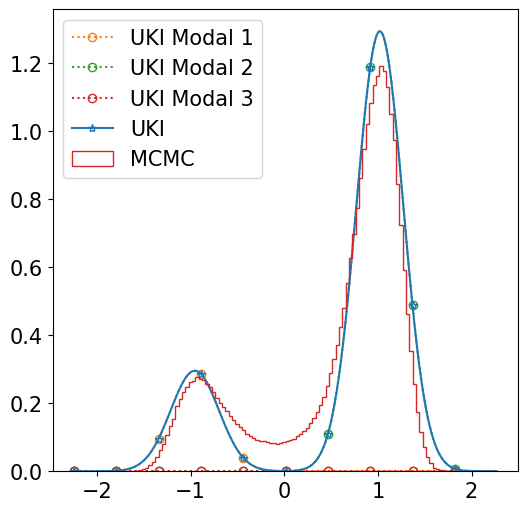

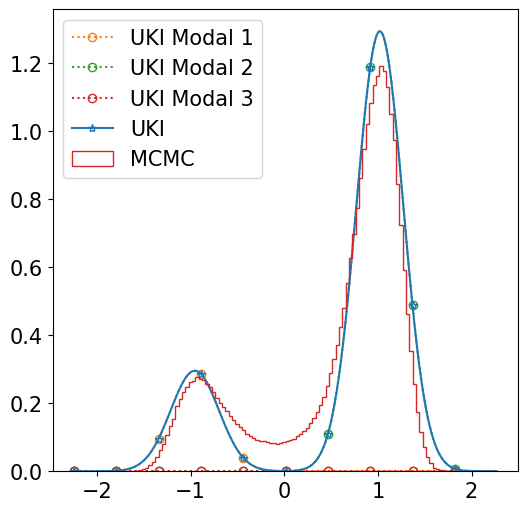

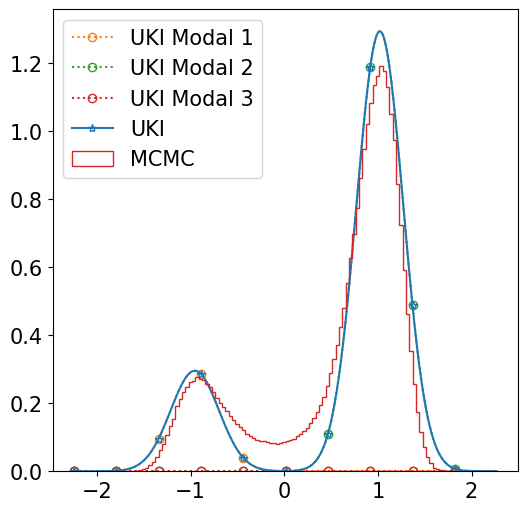

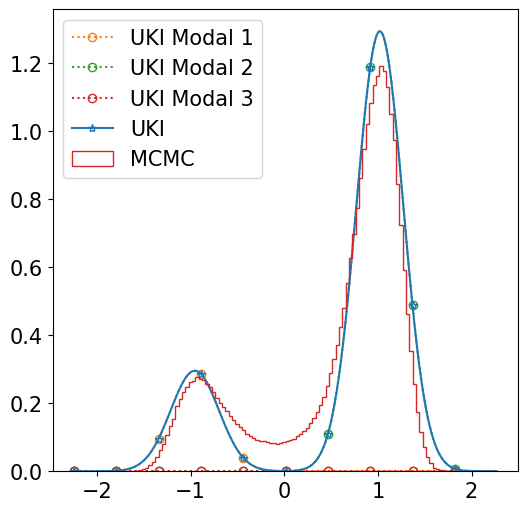

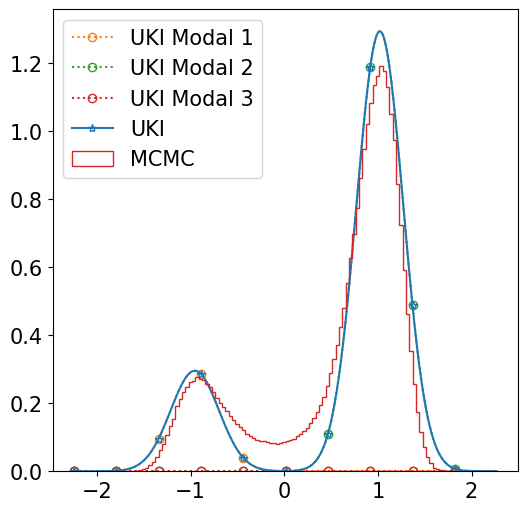

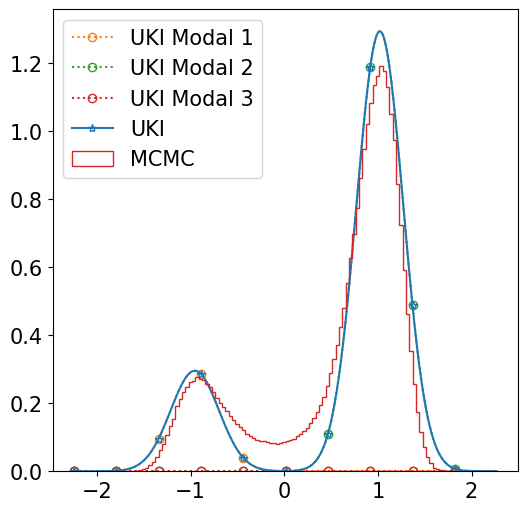

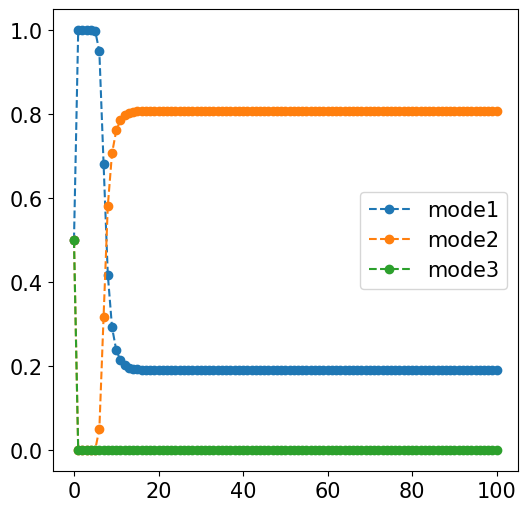


("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.06229289843140311;;], [1.020162575670095], [1.0091374154023875], 7.907554642455189e-66, 4.19122998058387e-33)
logθ_w_n = [-0.9768631539694167, -0.2442523209135531, -0.2442531867572109]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, [0.06661245668068862;;], [-0.9555419215903616], [-0.9774402919034472], 0.22043578941168493, 0.9925857043487872)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, [0.06229363780959903;;], [1.0201602713473847], [1.0091330386786077], 0.44849753527387926, 0.9981608023529881)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :], θ_mean_p[i, :], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, [0.062292980239970874;;], [1.0201623207065662], [1.0091369311399623], 7.907508350044503e-66, 4.191217808075161e-33)
logθ_w_n = [-0.9768631539694167, -0.2442523209135

┌ Info: ("updata : θ_mean = ", [-0.9555419215903616; 1.0201602713473847; 1.02018166198809;;], " θ_p_mean = ", [-0.9774402919034472; 1.0091330386786077; 1.009173664346411;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-0.9555419215903616; 1.0201602713473847; 1.0201792945461534;;], " θ_p_mean = ", [-0.9774402919034472; 1.0091330386786077; 1.0091691683388166;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-0.9555419215903616; 1.0201602713473847; 1.0201771891970808;;], " θ_p_mean = ", [-0.9774402919034472; 1.0091330386786077; 1.0091651700088153;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:529
┌ Info: ("updata : θ_mean = ", [-0.9555419215903616; 1.0201602713473847; 1.0201753169101293;;], " θ_p_mean = ", [-0.9774402919034472; 1.0091330386786077; 1.0091616142442286;;])
└ @ Main /Users/huang/Desktop/Code/InverseProb

PyObject <matplotlib.legend.Legend object at 0x1a8ae2cd0>

In [20]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.5, μ_0 = 3.0,  σ_0 = 2.0, Run_MCMC = true, plot_every = 5) 

In [24]:
include("../Inversion/GMKI.jl")
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.2, μ_0 = 3.0,  σ_0 = 2.0, Run_MCMC = true, plot_every = 5) 

("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :]) = ("mode : ", 1, [0.25;;], [-3.0])
("mode : ", i, θ_w[i], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, 0.5, 0.9234830506263487, 0.9234830506263487)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :]) = ("mode : ", 2, [0.25;;], [3.0])
("mode : ", i, θ_w[i], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, 0.5, 1.172431691654637, 1.172431691654637)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :]) = ("mode : ", 3, [0.25;;], [-2.0])
("mode : ", i, θ_w[i], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, 0.5, 0.960885750651485, 0.960885750651485)
logθ_w_n = [7981.7533627861085, 6725.779658494401, 388.8028960558412]
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :]) = ("mode : ", 1, [0.007989147061887247;;], [-1.768182219220261])
("mode : ", i, θ_w[i], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, 1.0, 0.7010397580490582, 0.7010397580490582)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :]) = ("mode : ", 2, [0.008602905281983986;;], [1.7221007234943078])
("mode : ", i, θ_w[i],

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("updata : θ_mean = ", [-3.0; 3.0; -2.0;;], " θ_p_mean = ", [-3.1860942579513636; 3.068301012235045; -1.7473190922638135;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:530
┌ Info: ("updata : θ_mean = ", [-1.768182219220261; 1.7221007234943078; -1.176551132845113;;], " θ_p_mean = ", [-1.7559724531576721; NaN; NaN;;])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:530


LoadError: PosDefException: matrix is not Hermitian; Cholesky factorization failed.